In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [4]:
import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from q_learning_bins import plot_running_avg

In [14]:
# so you can test different architectures
class HiddenLayer:
    def __init__(self, M1, M2, f= tf.nn.tanh, use_bias= True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
        self.f = f
    
    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)
    

In [16]:
# approximates pi(a | s)
class PolicyModel:
    def __init__(self, D, K, hidden_layer_sizes):
        # create the graph
        # K = number of actions
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
            
        # final layer
        # layer = HiddenLayer(M1, K, lambda x: x, use_bias= False)
        layer = HiddenLayer(M1, K, tf.nn.softmax, use_bias= False)
        self.layers.append(layer)
        
        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name = 'X')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name= 'actions')
        self.advantages = tf.placeholder(tf.float32, shape= (None, ), name= 'advantages')
        
        # calculate output and cost
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        p_a_given_s = Z
        
        self.predict_op = p_a_given_s
        
        selected_probs = tf.log(
            tf.reduce_sum(
                p_a_given_s * tf.one_hot(self.actions, K),
                reduction_indices= [1]
            )
        )
        
        cost = - tf.reduce_sum(self.advantages * selected_probs)
        self.train_op = tf.train.AdagradOptimizer(10e-2).minimize(cost)
        # self.train_op = tf.train.AdamOptimizer(10e-2).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-5, momentum= 0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(10e-5).minimize(cost)
        
    def set_session(self, session):
        self.session = session
        
    def partial_fit(self, X, actions, advantages):
        X = np.atleast_2d(X)
        actions = np.atleast_1d(actions)
        advantages = np.atleast_1d(advantages)
        self.session.run(
            self.train_op,
            feed_dict = {
                self.X: X,
                self.actions: actions,
                self.advantages: advantages,
            }
        )
    
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict= {self.X: X})
    
    def sample_action(self, X):
        p = self.predict(X)[0]
        return np.random.choice(len(p), p = p)
    


In [7]:
# approximates V(s)
class ValueModel:
    def __init__(self, D, hidden_layer_sizes):
        # create the graph
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
        
        # final layer
        layer = HiddenLayer(M1, 1, lambda x: x)
        self.layers.append(layer)
        
        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape= (None, D), name= 'X')
        self.Y = tf.placeholder(tf.float32, shape= (None,), name= 'Y')
        
        # calculate output and cost
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = tf.reshape(Z, [-1]) # the output
        self.predict_op = Y_hat
        
        cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
        self.train_op = tf.train.GradientDescentOptimizer(10e-5).minimize(cost)
        # self.train_op = tf.train.AdamOptimizer(10e-3).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-3, momentum= 0.9).minimize(cost)
        
    def set_session(self, session):
        self.session = session
        
    def partial_fit(self, X, Y):
        X = np.atleast_2d(X)
        Y = np.atleast_1d(Y)
        self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})
        
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict= {self.X: X})
    

In [8]:
def play_one_td(env, pmodel, vmodel, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = pmodel.sample_action(observation)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        # update the models
        V_next = vmodel.predict(observation)
        G = reward + gamma * np.max(V_next)
        advantage = G - vmodel.predict(prev_observation)
        pmodel.partial_fit(prev_observation, action, advantage)
        vmodel.partial_fit(prev_observation, G)
        
        if reward == 1: # if we change the reward to -200
            totalreward += reward
        iters +=1
        
    return totalreward

In [18]:
def play_one_mc(env, pmodel, vmodel, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    states = []
    actions = []
    rewards = []
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = pmodel.sample_action(observation)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        if done:
            reward = -200
            
        states.append(prev_observation)
        actions.append(action)
        rewards.append(reward)
        
        if reward == 1: # if we changed the reward to -200
            totalreward += reward
            
        iters +=1
        
    returns = []
    advantages = []
    G = 0
    for s, r in zip(reversed(states), reversed(rewards)):
        returns.append(G)
        advantages.append(G - vmodel.predict(s)[0])
        G = r + gamma * G
        
    returns.reverse()
    advantages.reverse()
    
    # update the models
    pmodel.partial_fit(states, actions, advantages)
    vmodel.partial_fit(states, returns)
    
    return totalreward

In [12]:
def main():
    env = gym.make('CartPole-v0')
    D = env.observation_space.shape[0]
    K = env.action_space.n
    pmodel = PolicyModel(D, K, [])
    vmodel = ValueModel(D, [10])
    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)
    pmodel.set_session(session)
    vmodel.set_session(session)
    gamma = 0.99
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 500
    totalrewards = np.empty(N)
    for n in range(N):
        totalreward = play_one_mc(env, pmodel, vmodel, gamma)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())
            
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(totalrewards)

episode: 0 total reward: 23.0 avg reward (last 100): 23.0
episode: 100 total reward: 142.0 avg reward (last 100): 130.554455446
episode: 200 total reward: 199.0 avg reward (last 100): 177.306930693
episode: 300 total reward: 199.0 avg reward (last 100): 183.801980198
episode: 400 total reward: 199.0 avg reward (last 100): 192.574257426
avg reward for last 100 episodes: 192.82
total steps: 87651.0


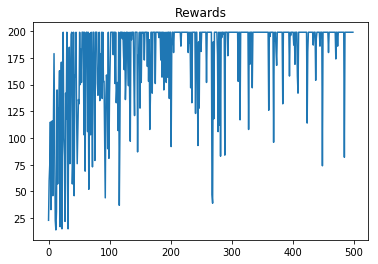

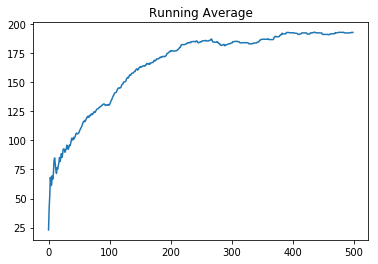

In [19]:
if __name__ == '__main__':
    main()